In [14]:
#import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import utm
import geopy as gp
import geopy as gp
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

    1. Introduction:

Our project was inspired by our own experiences with the problems of persistent potholes–a hinderance that seems to cause universal frustration. According to Wilkens, the process of fixing a pothole is prioritized by complaint tickets reported by the city, which indicates that pothole areas with the most complaints take precedence (Wilkens, 2017). In addition to this, there are merely "eight two-person crews that work each 10 hours shift" (Wilkens, 2017). This results in an inefficient method because the process of fixing potholes is not prioritized effectively to concentrate on the areas that need it most. 
 
Research Question:

People have become so desensitized to potholes that their frustration for them have become an everyday routine. For the safety of people and their cars, we asked, what approaches can be taken towards increasing the efficiency of pothole repair? And where should San Diego be allocating their pothole workers and resources? 

Hypothesis:

We predict that the following areas of concern are where the largest problems of potholes reside. These include the hindering of the bus transit system, reducing revenue earned from nearby affected parking meters, and a correlation of a slower rate a pothole is fixed with neglected areas of lower socioeconomic status in San Diego.

    2. Methods:

          ****need to figure out how to smoothly incorporate the Additional Data Analysis Ya'll did last night**** 
                           (time and date it took to fill in near bus stops and populations) 
                           *new bus stop data--> can go under bus transits*
                           *new populations data--> can go under a completely new category*


                                                    GEOCODER

In [ ]:
neighborhoods = np.zeros((len(df['lat']),1))
df['Neighborhood'] = neighborhoods

#get neighborhoods of potholes
import geocoder 

#SET THE X AND Y
x = 
y = 
neighborhood = []

for i in range (x,y):
    latitutde = df.iloc[[i]]['lat']
    longitude = df.iloc[[i]]['long']
    time.sleep(.1)
    g = geocoder.google([latitutde, longitude], method = 'reverse').json
    if 'neighborhood' not in g:
         df.ix[i, 'Neighborhood'] = 'NaN'
    else:
        neighb = g['neighborhood']
        df.ix[i, 'Neighborhood'] = neighb
    
# for i in range (1401, len(df['long'])):
#     neighborhood.append('ADD ME')
# df['Neighborhood'] = neighborhood

                                         DATA SET: "GET IT DONE" (POTHOLES)

First of all, "get it done" is a service that people report non-emergency problems to about a city such as San Diego. To begin our analyses of pothole impact, we needed to firstly clean the “Get it Done” data because it was filled with extraneous information about "get it done" reports such as graffiti locations, abandoned car locations, etc. 


In [6]:
# #upload get it done data set
# df = pd.read_csv('/clean_data/cleaned_get_it_done_closed_potholes.csv')

# #dropping unnecessary data
# df = df.drop(['address', 'sap_notification_number', 'sap_problem_code', 'service_subtype', 'source', \
#             'referred_email_update', 'referral_email', 'functional_location', 'description', \
#             'agency_responsible' , 'sap_problem_category', 'case_record_type', 'updated_datetime',\
#             'service_request_id', 'parent_case_number'], axis = 1)

# #drop all potholes 
# df = df.drop(df[df.sap_problem_type != 'Pothole'].index)

# #drop all NaNs for Long and Lat
# df = df.dropna(subset = ['long'])
# df = df.dropna(subset = ['lat'])

# #drop all non-active potholes
# df = df.drop(df[df.status_description == 'Duplicate'].index)
# df = df.drop(df[df.status_description== 'Closed'].index)
# df = df.drop(df[df.status_description=='Closed - Referred'].index)

After cleaning the data, we were left with the most relevant information about potholes: their latitude, longitude, and their status (open or closed). We then used this data with all the following data sets, as shown below in the rest of the report. 

                           DATA SET: "PARKING METERS LOCATIONS AND PARKING METERS TRANSACTIONS"
We looked into parking meter locations around San Diego, their vicinity to potholes, and whether that affected how much they were making. We began by cleaning the data and removing irrelevant columns for both the parking meters locations and parking meters transactions:


In [ ]:
#upload parking meters locations
raw_trans = pd.read_csv('/raw_data/treas_meters_2017_pole_by_mo_day_datasd.csv')

In [ ]:
#upload parking meters transactions 
clean_parking_loc = pd.read_csv('/clean_data/parking_meter_location.csv')

#drop rows with zero longitude and latitudes 
clean_parking_loc = clean_parking_loc.drop(clean_parking_loc[clean_parking_loc.longitude==0.000000].index)

#rename pole column header of clean_parking_loc data to 'pole_id' to match the header of the clean_combined_parking_meter_data dataset
clean_parking_loc.columns= ['index', 'pole_id', 'longitude', 'latitude']

#drop index column
clean_parking_loc = clean_parking_loc.drop(['index'], axis = 1)

#merge datasets based on matching parking meter IDs
merged_id = pd.merge(clean_parking_loc, clean_trans, on='pole_id')

After cleaning the data set, we were left to work with the latitude, longitude, and pole identifications of the parking meters. The parking meter transactions were added up based on pole ID and then combined with the parking meter location data.  

In [ ]:
#sum of transaction amount based on pole_id
raw_trans['combined_parking_meter_data'] = raw_trans.groupby(['pole_id'])['sum_trans_amt'].transform('sum')

#drop columns 'meter_type', 'month', 'day', 'num_trans'
clean_trans = raw_trans.drop(['meter_type', 'month', 'day', 'num_trans'],axis = 1)

#eliminated duplicate sum value for each pole_id
clean_trans = clean_trans.drop_duplicates(subset=['pole_id'], keep='first')

#merge datasets based on matching parking meter IDs
merged_id = pd.merge(clean_parking_loc, clean_trans, on='pole_id')

                                                        ---

Firstly, we compared the distribution of the distances of the parking meters to the closest pothole to random points around San Diego to the closest pothole. We were able to generate these random points by using the CA shapefile with QGIS, creating 60000 random points.

In [ ]:
#graphing (and code???) of both random points + min distance to parking meters?


In [ ]:
#Distances from Potholes to nearest Parking Meters
open_pot = pd.read_csv('Pr_087/clean_data/cleaned_get_it_done_open_potholes.csv')
open_pot = open_pot[~np.isnan(open_pot['long'])]
open_pot = open_pot[open_pot['long'] != 0]

meter_data = pd.read_csv('Pr_087/raw_data/raw_parking_meter_location.csv')
meter_data = meter_data[~np.isnan(meter_data['longitude'])]
meter_data = meter_data[meter_data['longitude'] != 0]

open_pot_coordinates = np.asarray(open_pot[['lat','long']])
meter_data_coordinates = np.asarray(meter_data[['latitude','longitude']])

#remove outlier
open_pot_coordinates = np.delete(open_pot_coordinates, 2293 ,axis=0) 

#Convert to utm
open_pot_coordinates = latlon_to_utm(open_pot_coordinates)
meter_data_coordinates = latlon_to_utm(meter_data_coordinates)

dist_meter_data = scipy.spatial.distance.cdist(open_pot_coordinates,meter_data_coordinates)
min_dist_indices = np.zeros(dist_meter_data.shape[0])
min_dists = np.zeros(dist_meter_data.shape[0])
for i in range(0,dist_meter_data.shape[0]):
    _ = np.argmin(dist_meter_data[i])
    min_dists[i] = dist_meter_data[i][_]
    min_dist_indices[i] = _    
    
min_dists2 = np.zeros(dist_meter_data.shape[1])
for j in range(0,dist_meter_data.shape[1]):
    _ = np.argmin(dist_meter_data.T[j])
    min_dists2[j] = dist_meter_data[_][j]
#merge meters with min dist to pothole
meter_data['nearest_pothole_dist'] = min_dists2
meter_data.to_csv('TimLeeBro.csv')
    
plt.close()
plt.figure(figsize=(10,10))
# plt.hist(np.log(min_dists), 50)
plt.hist(min_dists, 50)
plt.title('Distances_From_Potholes_To_Nearest_Parking_Meters')
# plt.xlabel('Distance in meters (logged)')
plt.xlabel('Distance in meters')
plt.ylabel('Occurrences')
plt.show()
plt.close()
print('Mean:',np.mean(min_dists))

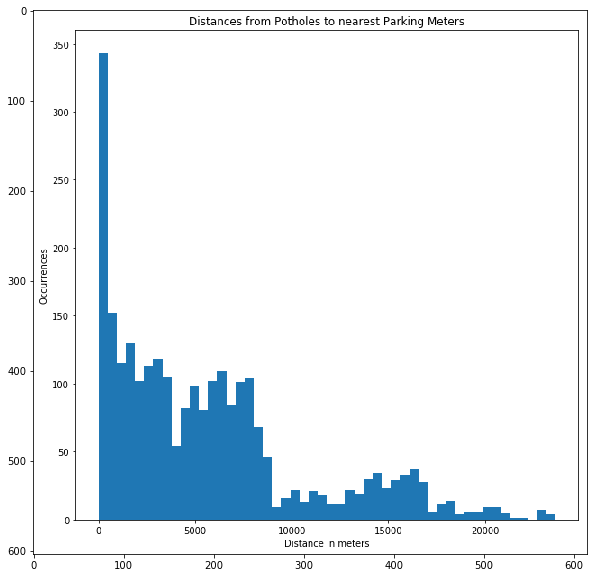

In [38]:
from scipy import misc
plt.imshow(misc.imread("/Users/maggie/Desktop/COGS108/Pr_087/plots/Distances_From_Potholes_To_Nearest_Parking_Meters.png"))
plt.show()

Mean: 5631.00322684

In [ ]:
#Distances from Random Points to Parking Meters
random_points = pd.read_csv('Pr_087/clean_data/randPoints6000.csv')
random_points_coordinates = np.asarray(random_points[['Y','X']])

#convert to utm
random_points_coordinates = latlon_to_utm(random_points_coordinates)

dist_meter_data = scipy.spatial.distance.cdist(random_points_coordinates,meter_data_coordinates)
min_dist_indices = np.zeros(dist_meter_data.shape[0])
min_dists = np.zeros(dist_meter_data.shape[0])
for i in range(0,dist_meter_data.shape[0]):
    _ = np.argmin(dist_meter_data[i])
    min_dists[i] = dist_meter_data[i][_]
    min_dist_indices[i] = _    

plt.close()
plt.figure(figsize=(10,10))
# plt.hist(np.log(min_dists), 50)
plt.hist(min_dists, 50)
plt.title('Distances from Random Points to Parking Meters')
# plt.xlabel('Distance in meters (Logged)')
plt.xlabel('Distance in meters')
plt.ylabel('Occurrences')
plt.show()
plt.close()
print('Mean:',np.mean(min_dists))

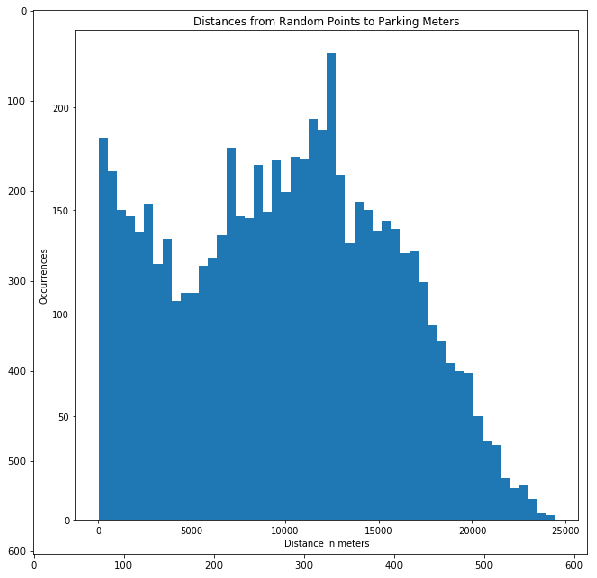

In [35]:
from scipy import misc
plt.imshow(misc.imread("/Users/maggie/Desktop/COGS108/Pr_087/plots/Distances_From_Random_Points_To_Nearest_Parking_Meters.png"))
plt.show()

Mean: 1167.28134835

We found that these graphs did not show any evidence of significant data, especially because there is evidently a large concentration of parking in meters in one area, as seen in the graph above. Additionally, the average results of each of these distributions do not have a major difference between them, which is shown below.

In [ ]:
#insert averages of both

                                                        ---

To ensure we did not need further analysis, we wanted to visualize and see where the parking meters were located using Arc GIS:

In [ ]:
#TIM'S GIS GRAPH-- probs .load 
# arcgis = Image.open("your_image_here");
# arcgis.show();

As a result of this visualization, we concluded that it was not wise to further analyze this data because most of the parking meters listed from this set is concentrated in specific areas mainly in the downtown region, as seen above.

                                         DATA SET: "TRANSIT STOPS LOCATIONS" 

We followed a similar procedure to that of the parking meters for analyzing the bus stop locations. We started by cleaning the data set:

In [ ]:
# #upload bus stops
# bus_stops= pd.read_csv('/raw_data/CITY.TRANSIT_STOPS_GTFS_datasd.csv')

# #dropping irrelevant columns 
# clean_bus_stops = bus_stops[['LONGITUDE', 'LATITUDE']]

We were left with just the latitude and longitude of the bus stops, which we would again then compare the distances to the potholes with the random points obtained from earlier:

In [ ]:
#insert graphs (and code???) of random points + min distance to bus stops 

In [ ]:
#Distances of Potholes to nearest Bus Stop
dist_bus_data = scipy.spatial.distance.cdist(open_pot_coordinates,bus_stops_coordinates)
min_dist_indices = np.zeros(dist_bus_data.shape[0])
min_dists = np.zeros(dist_bus_data.shape[0])

for i in range(0,dist_bus_data.shape[0]):
    _ = np.argmin(dist_bus_data[i])
    min_dists[i] = dist_bus_data[i][_]
    min_dist_indices[i] = _   
    #Filter outliers
#     if dist_bus_data[i][_] > 7160:
#         print('WTF',i,':',dist_bus_data[i][_])

plt.close()
plt.figure(figsize=(10,10))
# plt.hist(np.log(min_dists), 50)
plt.hist(min_dists,50)
plt.title('Distances of Potholes to nearest Bus Stop')
# plt.xlabel('Distance in meters (logged)')
plt.xlabel('Distance in meters')
plt.ylabel('Occurrences')
plt.show()
plt.close()
print('Mean:',np.mean(min_dists))

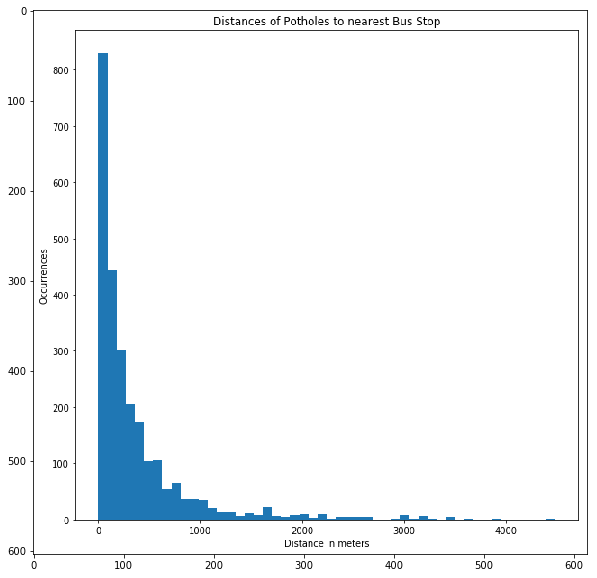

In [36]:
from scipy import misc
plt.imshow(misc.imread("/Users/maggie/Desktop/COGS108/Pr_087/plots/Distances_From_Potholes_To_Nearest_Bus_Stop.png"))
plt.show()

In [ ]:
#Distances from Random Locations to nearest Bus Stops
plt.close()
plt.close()
random_points = pd.read_csv('Pr_087/clean_data/randomPoints.csv')
random_points_coordinates = np.asarray(random_points[['Y','X']])
random_points_coordinates = latlon_to_utm(random_points_coordinates)
dist_bus_data = scipy.spatial.distance.cdist(random_points_coordinates,bus_stops_coordinates)
print(np.mean(dist_bus_data))
min_dist_indices = np.zeros(bus_data.shape[0])
min_dists = np.zeros(dist_bus_data.shape[0])
for i in range(0,bus_data.shape[0]):
    _ = np.argmin(dist_bus_data[i])
    min_dists[i] = dist_bus_data[i][_]
    min_dist_indices[i] = _    
plt.figure(figsize=(10,10))
plt.hist(np.log(min_dists), 50)
# plt.hist(min_dists, 50)
plt.title('Distances from Random Locations to nearest Bus Stops')
plt.xlabel('Distances in meters logged')
# plt.xlabel('Distances in meters')
plt.ylabel('Occurrences')
plt.show()
plt.close()
print('Mean:',np.mean(min_dists))

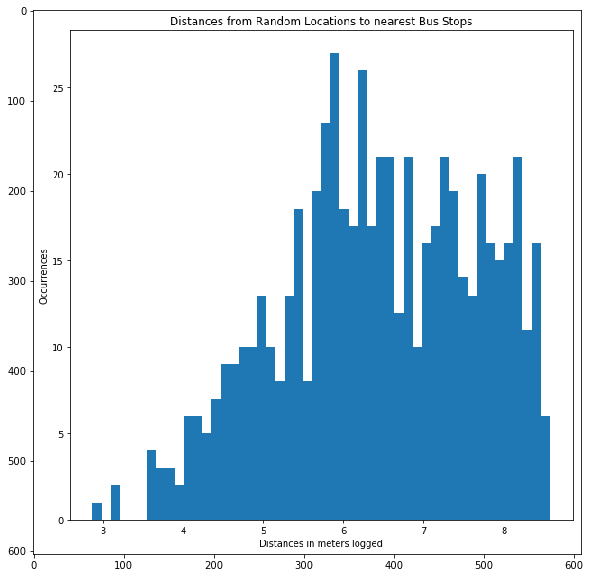

In [37]:
from scipy import misc
plt.imshow(misc.imread("/Users/maggie/Desktop/COGS108/Pr_087/plots/Distances_From_Random_Locations_To_Nearest_Bus_Stops.png"))
plt.show()

From both distribution graphs, we were able to conclude that there was actually a significant result. As seen by the averages below, the averages of the minimum distance of potholes to the bus stops compared with the random points is much smaller. This indicates that the results are not just by chance; there are more potholes allocated near bus stop locations.  

In [ ]:
#insert averages

                                DATA SET: "Neighborhood_MedianValuePerSqft_AllHomes" 

We then used Zillow’s price per square foot data to determine the socioeconomic effect of potholes. We first cleaned data to only use the locations based in San Diego. 

In [ ]:
# #upload zillow data
# zillowpd = pd.read_csv('/raw_data/Neighborhood_MedianValuePerSqft_AllHomes.csv') 

# #remove all counties not san diego
# zillowpdsd = zillowpd[zillowpd['CountyName'] == 'San Diego'] 
# #remove uneccessary columns
# zillowpdsd = zillowpdsd.drop('RegionID', 1)
# zillowpdsd = zillowpdsd.drop('State', 1)
# zillowpdsd = zillowpdsd.drop('SizeRank', 1)
# #remove all but latest rent info
# zillowpdsd2 = zillowpdsd[['RegionName', 'City','Metro','CountyName','2017-03']]


We found that the Zillow data only contained neighborhoods, thus we were not able to directly map the price/sqft with the potholes. So, we used geocoder with the pothole data to determine the neighborhoods of each pothole, which we could then map to the Zillow prices. Yet, we found that some names did not match, which we found that we needed to use Bing API, which Zillow uses for its neighborhoods to fill in the missing gaps:

In [ ]:
#insert some google/ bing api?????

After finding the actual neighborhoods where all the potholes resided, we compared this data with the time it took for a pothole to close and measured the correlation between them:

In [ ]:
#tim cleaning up to get time 
#tim graphs on time + neighborhoods and also Pearson/Spearman stuff

Evidently, the data is normally distributed. There is no real correlation between the time it takes for a pothole to close and the socio-economic status of a neighborhood. 

    3. Conclusion/ Discussion

*need general results but does not need to be fleshed out for tomorrow

    4. Resources


John Wilkens 2017: http://www.sandiegouniontribune.com/news/transportation/sd-me-pothole-repair-20170208-story.html 